---
title: "Chapter 2, Part 2 : Logistic Regression"
subtitle: "Machine Learning"
date: "January 2025"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez \inst{1}
institute: 
  - \inst{1} Based on notes by Professors A.Muñoz, J.Portela & J.Pizarroso
bibliography: "../MLMIC.bib"
execute:
  echo: true
code-overflow: wrap
format: 
  html: 
    toc: true
    code-fold: show
    code-summary: "Hide the code"
    code-tools: true
    embed-resources: true
---

# Introduction


::: {.callout-note icon=false}
# Moving Along the Modeling Process

In our previous session we show to preprocess a data set for a classification problem, and so we are ready to move to the last three steps of our plan to solve that problem: 

3) Choose a model
4) Fit the parameters of the model
5) Assess the model quality

:::

::: {.callout-note icon=false}

## Logistic Regression

In this session we will meet our fist Machine Learning model. **Logistic Regression is a classical model for binary classification problems.** It can often be considered as a baseline or reference model. Logistic Regression is fast to train and fast to predict. And it is arguably the best of close to the best model in terms of interpretability. Therefore any *fancier*, more sophisticated model is usually compared against logistic regression to decide if the costs in terms of computation and interpretability are reasonable.

::: 


---

::: {.callout-note icon=false}

## Probabilistic vs Hard Approach

Recall that a classification method uses the probabilistic (soft) approach if it  **predicts the conditional probability** that the output $y$ equals 1, given an input value $\mathbf x$.
$$P(y = 1 | \mathbf x) = f(\mathbf x)$$
Logistic regression is an example of a probabilistic classification method. A classification method that **directly predictis the class uses the hard approach**. Keep in mind that every probabilistic classifier can be turned into a hard classifier by setting a **probability threshold**.
::: 

::: {.callout-note icon=false}

## Probabilistic vs Hard Approach in Logistic Regression 

The probabilistic approach in Logistic Regression uses the following equation to model conditional probabilities:
$$P(y = 1 | \bar x) = \dfrac{e^{b_0 + \bar b_1 \bar x}}{1 + e^{b_0 + \bar b_1 \bar x}}$$
Where, in general, $\bar x$ is a multidimensional input vector. 

::: 


---

# The One Dimensional Case.

::: {.callout-note icon=false}

## Logistic Curves

We will first look at the one dimensional case: a classification problem with a single numeric predictor. This will help us understand the higher dimensional logistic regression.

When the input $x$ is one dimensional the expression  
$$p(x) = \dfrac{e^{b_0 + b_1 x}}{1 + e^{b_0 +  b_1 x}}$$
defines a family of **sigmoid (s-shaped) curves** called **logistic curves** like the one below, with heights between 0 and 1. You can use the following link to explore them.  
[Dynamic Logistic Curve Exploration](https://www.geogebra.org/m/hdptspjg)

![](./fig/02-01_LogisticCurve.png){width=50% fig-align="center" fig-alt="Logistic Curve"}

::: 


---

::: {.callout-note icon=false}

## Python Example for the One Dimensional case

To illustrate logistic regression in the one dimensional case we will use the dataset stored in the `Default.csv` file (already in this session's folder). This synthetic dataset is one of the example files used in [@ISLP2023, see the References below] and you can find specific information about the dataset in this link:  
[https://islp.readthedocs.io/en/latest/datasets/Default.html](https://islp.readthedocs.io/en/latest/datasets/Default.html)

$\quad$  

The dataset has a binary output target `Default` (levels *No* and *Yes*) and four input variables (predictors): one binary factor *Student* and two numeric inputs, *Income* and *Balance*. Sine we want to start with a one dimensional example we will be dropping two inputs, and so we will **try to predict `Default` from the values of `balance` alone.**

$\quad$

Besides, even though the dataset contains a large number of rows, we will consider a smaller sample with only $N = 1200$ rows of the table (in fact, two such samples). The reason for this is that we want to discuss below the influence of the particular sample data in the modeling process. And this impact is easier to show with smaller samples. 

:::


---

::: {.callout-note icon=false}

## Load the Dataset

Remember that it is always recommended to explore the file with a text editor beforehand.

:::

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

df = pd.read_csv('Default.csv')
df.head(4)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935



---

::: {.callout-note icon=false}

## Drop Unused Columns and Set Variable Types

We drop two inputs and set the type of the output to categorical, checking the result.

:::

In [2]:
df.drop(columns=["student", "income"], inplace=True)
df["default"] = df["default"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   default  10000 non-null  category
 1   balance  10000 non-null  float64 
dtypes: category(1), float64(1)
memory usage: 88.1 KB



---

::: {.callout-note icon=false}

## Set Standard Names for the Variables

This improves readability and readability of our code in the course.

:::

In [3]:
output = 'default'
cat_inputs = []
df[cat_inputs + [output]] = df[cat_inputs + [output]].astype("category")


In [4]:
inputs = df.columns.drop(output)
num_inputs = inputs.difference(cat_inputs).tolist()
inputs

Index(['balance'], dtype='object')


---

::: {.callout-note icon=false}

## Check for Missing Values and Take a Random Sample of the Dataset

This synthetic dataset does not contain missing values.

:::

In [5]:
df.isnull().sum(axis=0)

default    0
balance    0
dtype: int64

We will only consider 1200 rows of the dataset, sampled without replacement. We use the [`sample` function from Pandas (read the docs!)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to do this and define standard names `X` and `Y`.

In [6]:
df1 = df.sample(n = 1200, random_state=1)

X = df1.drop(columns=output)
Y = (df1[output] == "Yes") * 1.0

::: {.callout-warning icon=false}

## Set the Random State

Setting the `random_state` in your code makes it reproducible and is **very important (and required in exams and assignments).** 

:::


---

::: {.callout-note icon=false}

## Split the Data into Training and Test

We will use 80% of the sample for training. Remember that we use stratified splits. 

:::

In [7]:
from sklearn.model_selection import train_test_split

XTR, XTS, YTR, YTS = train_test_split(X, Y,
                                      test_size=0.2,  # percentage preserved as test data
                                      random_state=1, # seed for replication
                                      stratify = Y)   # Preserves distribution of y


---

::: {.callout-note icon=false}

## Check for Outliers

No relevant outliers appear in the boxplot for `balance`.

:::

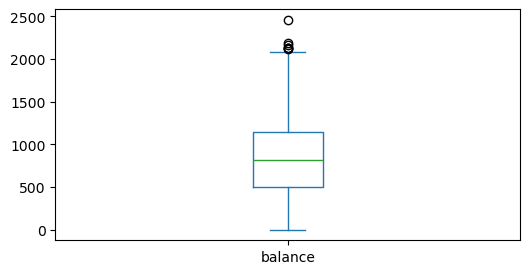

In [8]:
XTR_numeric_boxplots = XTR[num_inputs].plot.box(subplots=True, 
                                            layout=(1, len(num_inputs)), 
                                            sharex=False, sharey=False, figsize=(6, 3))


---

::: {.callout-note icon=false}

## Basic `balance` Statistics and Check for Imbalanced Default Classes

Observe that the difference in proportion between the two levels of the output  (< 4% positive cases) turns this into a **severely imbalanced classification problem.**

:::

In [9]:
XTR[num_inputs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
balance,960.0,840.746348,474.964796,0.0,504.265675,821.378068,1148.46777,2461.506979


In [10]:
YTR.value_counts(normalize=True)

0.0    0.967708
1.0    0.032292
Name: default, dtype: float64

Keep in mind that classification problems with imbalanced data such as this one are usually much harder.


---

::: {.callout-note icon=false}

## Distribution of the Numerical Input `balance`

The density curve for `balance` is symmetrical enough and bell-shaped, so we will not apply any further transformation, considering it as approximately normal.

:::

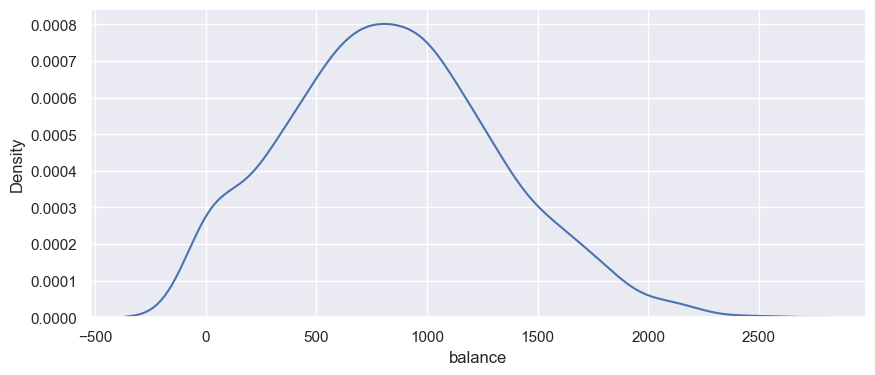

In [11]:
sns.set(rc={'figure.figsize':(10,4)});
sns.kdeplot(XTR, x = "balance");


---

::: {.callout-note icon=false}

## Back to the Logistic Curve

To improve our understanding of Logistic Regression, let us plot the data. In this plot the horizontal axis shows the input variable and the vertical coordinates 0 and 1 correspond to the two levels of the output $Y$.

:::

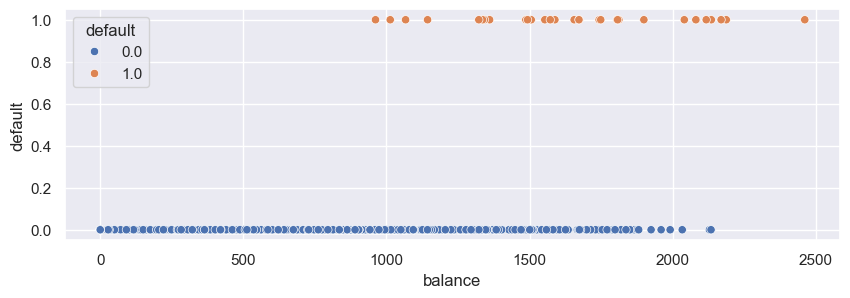

In [12]:
sns.set(rc={'figure.figsize':(10, 3)});
sns.scatterplot(XTR, x = "balance", y=YTR, hue=YTR);

What is the **modeling signal** that we see in this plot? In a nutshell: *higher values of balance correspond to an increased probability of default*. Remember that this is an imbalanced dataset!

---

Now imagine that we divide the range of the input into many bins:

![](./fig/02-03-LogisticModel-Dim1-01.png){width=95% fig-align="center" fig-alt="Logistic Curve"}

and for each bin we obtain the proportion of data points with $Y = 1$.

---

In the following picture the height of the green points represent precisely these proportions for each bin. 

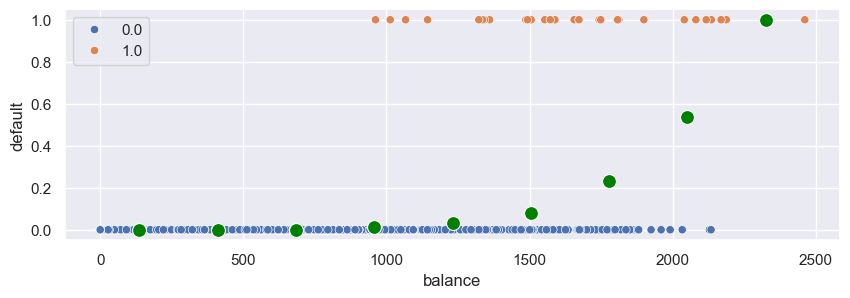

In [13]:
%run -i 2_2_plot_logistic_curve-01.py

And you can see that they are beginning to look like an s-shaped curve. 

In [14]:
# %load 2_2_plot_logistic_curve-01.py

::: {.callout-warning icon=false}

## Magic functions `%load` and `%run`

We used `%run -i` above to execute an external Python script. To actually include the code, uncomment the line with `%load` and execute that cell. You can [learn more about these *magic Jupyter functions* here.](https://ipython.readthedocs.io/en/stable/interactive/magics.html)

:::

---

In the figure below we have drawn by hand a sigmoid curve, to invite you to think about these closely connected questions:

+ Is this the best sigmoid curve that we can fit to the data? How do we decide that a curve is better than another one?
+ And in particular, how do we choose the values $b_0$ and $b_1$ in 
  $$f(x) = \dfrac{e^{b_0 + b_1 x}}{1 + e^{b_0 +  b_1 x}}$$
  that corresond to the best curve? Both theoretically and with Python!
![](./fig/02-03-LogisticModel-Dim1-02.png){width=95% fig-align="center" fig-alt="Temptative Logistic Curve "}

That is the subject of the next section.

---

# Fitting the Logistic Regression Model

::: {.callout-note icon=false}

## Likelihood

You probably know that in *linear regression* the least squares method is used to fit a linear model to the data. We will discuss that problem in due time, when we talk about regresion methods. , could we use the least squares method here to fit the sigmoid curve? The answer is, in principle, yes. But the resulting curve and model would not have good probabilistic properties. Therefore we will use an approach *that takes probability as starting point.*  
$\,$  

The **likelihood function** corresponding to a choice of $b_0, b_1$ in the sigmoid curve and a given dataset $(x_0, y_0),\ldots, (x_n, y_n)$ is:
$$
{\mathcal{L}}(b_0, b_1) = \prod_{i: y_i = 1}p(x_i)\,\prod_{j: y_j = 0}(1 - p(x_j)),\qquad\text{where}\quad
p(x) = \dfrac{e^{b_0 + b_1 x}}{1 + e^{b_0 +  b_1 x}}
$$
The idea behind this equation is that the observations in the dataset are independent (i.e. we assume sampling with replacement) and therefore he likelihood represents *the probability of those coefficient values given the data we observed.*

Then we can use this as our fitting criterion: **the fit model will be one with coefficients that maximize the likelihood**. 

:::

---

::: {.callout-note icon=false}

## Log-Likelihood

Most optimization methods are implemented to find minimum values of functions. Besides, instead of a big product it is simpler to work with the derivatibves of a sum. Therefore, we consider the logarithm of the likelihood, called the **log-likelihood** defined as follows (up to a positive constant factor)
$$
\log(\mathcal{L})(b_0, b_1) = \sum_{i = 1}^n \left(y_i \log(p(x_i)) + (1 - y_i) \log(1 - p(x_i))\right)
$$
To see why this is the logarithm of the likelihood keep in mind that for each data point $(x_i, y_i)$ we have either $y_i = 1$ or $y_i = 0$. Thus only one of the terms in the inner sum is used.

And we reformulate our fitting criterion: **the fit model will be one with coefficients that minimize $-\text{(log-likelihood)}$** (i.e., minus the logarithm of the likelihood).

:::

---

::: {.callout-note icon=false}

## Logistic Regression Model and scikit-learn Pipelines 

The pipeline framework that we have seen for preprocessing is easily extended with a modeling step using `LogisticRegresion` from `scikit-learn`. Note that preprocessing in this one dimensional case is reduced to scaling. The fitting criterion we have described is implemented into the `LogisticRegression` object. We therefore extend the pipeline with this additional modeling step as follows:

:::

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

LogReg_pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('LogReg', LogisticRegression(penalty=None))])

_ = LogReg_pipe.set_output(transform="pandas")

---

::: {.callout-note icon=false}

## Model Fitting with the Pipeline

To fit the Logistic Regression model we jus call the `fit` method of the pipeline.

:::

In [16]:
LogReg_pipe.fit(XTR, YTR)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LogReg', LogisticRegression(penalty=None))])

In your notebook or in the html version of this document you will see an interactive diagram describing the structure  of the fitted pipeline. 

---

::: {.callout-note icon=false}

## Coefficients of the Model

The coefficients $b_0, b_1$ of the fitted model can be recovered as properties of the `LogReg` step of the pipeline. We use `named_steps` to inspect the step we are interested in. 

Here we also use the functions/objects [`hstack`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html), [`newaxis`](https://numpy.org/doc/stable/reference/constants.html) and [`ravel`](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) to shape the coefficients into a convenient structure.

:::

In [17]:
LogReg_coeff = np.hstack((LogReg_pipe.named_steps["LogReg"].intercept_[np.newaxis, :], 
                          LogReg_pipe.named_steps["LogReg"].coef_))
LogReg_coeff


array([[-5.30817437,  2.12345728]])

In [18]:
# b0, b1 = LogReg_coeff.ravel() # 
b0, b1 = LogReg_coeff[0,:]
b0, b1

(-5.30817436639617, 2.1234572808427155)

::: {.callout-warning  icon=false}

## The Fitted Coefficients use the Transformed (Scaled) Variables

In scikit-learn the coefficients of the fitted model correspond to the scaled input variables, and can not be directly interpreted in terms of the original ones (more details on this below). 

:::

::: {.callout-tip  icon=false}

### Exercise 001.

Look up the numpy functions and objects in the previous code cell using the links provided and figure out what they do in general and in our context.

:::

---

::: {.callout-note icon=false}

# Plotting the Logistic Model Curve

The remark about the scale of the fitted model in the previous section means that in order to plot the fitted curve we need to use the data transformed by the first step of the pipeline. 

::: 

In [19]:
LogReg_pipe.named_steps["scaler"]

StandardScaler()

In [20]:
XTR_transf = LogReg_pipe.named_steps["scaler"].transform(XTR)
XTR_transf

,balance
1537,0.081369
7707,2.117534
2165,0.390460
2445,0.636566
2899,0.662349
...,...
1520,-0.011529
5385,0.104316
9887,-0.237054
3720,1.326533


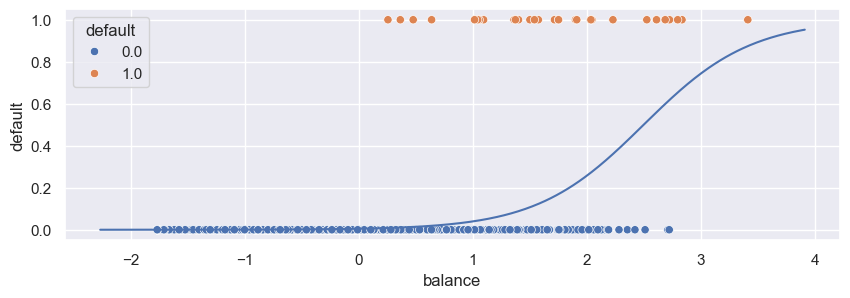

In [21]:
XTR_x = XTR_transf.iloc[:,0]
sns.set(rc={'figure.figsize':(10, 3)});
sns.scatterplot(x = XTR_x, y=YTR, hue=YTR)
x = np.linspace(min(XTR_x) - 0.5, max(XTR_x) + 0.5, 500)
y = 1 / (1 + np.exp(-b0 - b1 * x))
plt.plot(x, y, '-')

---

::: {.callout-note icon=false}

# Optional Detour: from Scratch Likelihood and Model Fitting

Python has several libraries that can be used to optimize functions. In particular this means that we can implement the -log-likelihood function by ourselves, and use one of these libraries to fit the logistic regression model. This is the purpose of the script 

:::

In [22]:
# %run -i 2_2_Likelihood_and_Fit_From_Scratch.py

::: {.callout-tip  icon=false}

### Exercise 002

Remove the comment in the previous cell, execute the cell to actually load the code, examine it and finally execute it again to see the results.

:::

---

::: {.callout-note icon=false}

# Back on the Track: Classical Inference in Logistic Regression

It is important to understand that the Logistic Model that we fitted depends on the particular sample that we are using. To get a better perspective on this essential point, we will now take a second independent sample with  another 1200 points from the `Default` data set and fit a model to this second dataset.

:::

::: {.callout-tip  icon=false}

### Exercise 003

The code to do this is in the script that apppears in the next cell. As before, remove the comment, execute the cell and load the code, examine and execute it again.

:::

In [23]:
# %run -i 2_2_Logistic_Model_Second_Sample.py

---

::: {.callout-note icon=false}

# Theoretical Model vs Fitted to Data Models

The result of the previous exercise illustrates that the models we fit are always data-dependent. We think of the coefficients $b_0, b_1$ for each of these models as estimates of the coefficients of a **theoretical model** that describes the relation between $X$ and $Y$:
$$P(y = 1 | x) = \dfrac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}$$

Note that here we use $\beta_0, \beta_1$ to represent the theoretical coefficients, as usual in Statistics. In this context, the coefficients that we have been calling $b_0$ and $b_1$ are **estimates** of the theoretical coefficients and we denote this with the symbols 
$$\hat\beta_0 = b_0,\, \hat\beta_1 = b_1$$

:::

---

::: {.callout-note icon=false}

# Inference on the Model Coefficients. Statsmodels vs Scikit-Learn

Since $\hat\beta_0, \hat\beta_1$ are estimates of $\beta_0, \beta_1$ we can use Statistical Inference to obtain confidence intervals and p-values to test the null hypothesis that $\hat\beta_1\neq 0$. Then we use the test to decide if the input variable $x$ is in fact useful to predict the output. 

In Python we have two libraries that can be used for this purpose: `statsmodels` and `scikit-learn`. The former is more oriented towards statistical inference and the latter towards machine learning. If we want to get confidence intervals and p-values we should use `statsmodels`. We do this in the cells below, using the `Logis` function from `statsmodels`. This function requires that we add a constant column of ones as the first column of the input data. The reason for this is that, in linear models, and in order to use Linear Algebra machinery, the constant term is treated as a coefficient of a variable that is always 1, like this:   
$$\beta_0 + \beta_1 x = \left(\begin{array}{cc}1 & x\end{array}\right)\left(\begin{array}{c}\beta_0 \\ \beta_1\end{array}\right)$$ 


:::

In [24]:
import statsmodels.api as sm
XTR_sm = sm.add_constant(XTR)
XTR_sm.head()


,const,balance
1537,1.0,879.373824
7707,1.0,1845.976439
2165,1.0,1026.104495
2445,1.0,1142.935257
2899,1.0,1155.175006


Now we are ready to fit the model with `statsmodels` 

In [25]:
logis_mod_sm = sm.Logit(YTR, XTR_sm)
logis_mod_sm_res = logis_mod_sm.fit()

Optimization terminated successfully.
         Current function value: 0.090488
         Iterations 9


and to obtain the confidence intervals and p-values for the coefficients using the `summary` method of the fitted model:

In [26]:
logis_mod_sm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  960
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Jan 2025   Pseudo R-squ.:                  0.3655
Time:                        10:11:24   Log-Likelihood:                -86.868
converged:                       True   LL-Null:                       -136.92
Covariance Type:            nonrobust   LLR p-value:                 1.453e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0776      0.938     -9.681      0.000     -10.915      -7.240
balance        0.0045      0.001      7.664      0.000       0.003       0.006
==============================================================================
"""

::: {.callout-note icon=false}

# Coefficients of the Model and Transformed Variables

If you recall the values $b_0, b_1$ of the coefficients for the model fitted with `scikit-learn` you will see that they are different from the values $\hat\beta_0, \hat\beta_1$ of the coefficients for the model fitted with `statsmodels` above. This is because the `scikit-learn` pipeline uses a scaler to transform the input data before fitting the model. The coefficients of the model are then the coefficients of the model fitted to the transformed data.  
The data we used to fit the model in `statsmodels` is not scaled. If we want to compare both approaches we should use the same data. And so below we will fit the model with `statsmodels` using the scaled data. Recall that the scaled data is stored in the `XTR_transf` variable.
:::

In [27]:
print(b0, b1)

-5.30817436639617 2.1234572808427155


In [28]:
XTR_transf_sm = sm.add_constant(XTR_transf)
logis_mod_sm2 = sm.Logit(YTR, XTR_transf_sm)
logis_mod_sm2_res = logis_mod_sm2.fit()
logis_mod_sm2_res.summary()

Optimization terminated successfully.
         Current function value: 0.090488
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  960
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Jan 2025   Pseudo R-squ.:                  0.3655
Time:                        10:11:24   Log-Likelihood:                -86.868
converged:                       True   LL-Null:                       -136.92
Covariance Type:            nonrobust   LLR p-value:                 1.453e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3125      0.472    -11.266      0.000      -6.237      -4.388
balance        2.1259      0.277      7.664      0.000       1.582       2.670
==============================================================================
"""

Now the coefficients of both fitted models look similar (the difference is due to the different optimization libraries used by scikit-learn and statsmodels).

::: {.callout-note icon=false}

# P-value interpretation

In this case we see that the p-value for the `balance` coefficient ($\beta_1$) is very small. Thus we reject the null (that says that this coefficient is zero) and conclude that `balance` in fact explains a part of the variability in `Default`. If you want to examine the p-values in detail use the code below:

:::

In [29]:
logis_mod_sm2_res.pvalues

const      1.931167e-29
balance    1.809077e-14
dtype: float64

---

# Multiple Logistic Regression

::: {.callout-note  icon=false}

## Logistic Regression Models for Classification Problems with Multidimensional Inputs

Up to this point we have considered an example of a binary classification problem with one-dimensional input. But at the beginning of this session we introduced Logistic Regression in a multidimensional setting, with the equation: 
$$P(y = 1 | \bar x) = \dfrac{e^{b_0 + \bar b_1 \bar x}}{1 + e^{b_0 + \bar b_1 \bar x}}$$
in which the input $\bar x$ is multidimensional (with fimension $p$), and the so called **logit**
$$w = b_0 + \bar b_1 \bar x = b_0 + b_1 x_1 + \cdots + b_p x_p =
\left(\begin{array}{cc}1 & x_1 & \cdots & x_p\end{array}\right)\left(\begin{array}{c}b_0 \\ b_1 \\ \vdots \\ b_p\end{array}\right)$$ 
is linearly dependent on $\bar x$. Note that the last matrix expression is the analoque of the one we used to incorporate the constant term in the one dimensional case.

:::



For example in a 2-dimensional problem where $\bar x= (x_1, x_2)$ instead of a sigmoid curve we get a logistic surface illustrated in the figure. Note that the level curves of such surface are still hyperplanes (straight lines) in the $(x_1, x_2)$ plane.
 

![](./fig/02-04-2dimLogisticModelSurface.png){width=85% fig-align="center" fig-alt="Two Dimensional Logistic Model Surface"}

---

::: {.callout-note  icon=false}

## Python Example of Multiple Logistic Regression

In the previous session we preprocessed an example with multidimensional inputs stored in the `Simdata0.csv` file. We will now go back to that file and use it to demonstrate how to fit a Logistic Regression model in this case. You will see that (at least initially) there is really not much of a difference with the one dimnsional case.

:::

::: {.callout-tip  icon=false}

### Exercise 004

The script in the next cell can be thought of as a draft for a *preprocessing template*. You have done this already, so remove the comment, execute the cell and load the code, examine and execute it again. The result will be a collection of training and test sets `XTR, YTR, XTS, YTS`. Do some basic EDA of this sets to make sure that you connect them with our work from the previous session.
What part of preprocessing has already been completed and what remains to be done?
:::

In [30]:
# %load "2_2_Exercise_001.py"

In [31]:
%run -i  "2_2_Exercise_001.py"

Preprocessing completed. Train and test set created.


---

::: {.callout-note  icon=false}

## Visualizing the Preprocessed Dataset

After the initial preprocessing in the script `2_2_Exercise_001.py` the inputs of the `XTR` dataset are `X1`, `X2` and the one hot encoding of `X4` into two variables `X4_A` and `X4_B`. Let us do a scatterplot to visualize this situation. We use color to represent the two classes of the output `YTR` and **we also use size** to represent `X4_A`.

:::

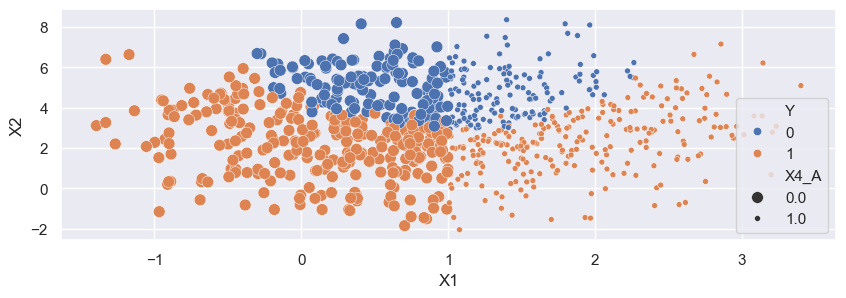

In [32]:
sns.set(rc={'figure.figsize':(10, 3)});
sns.scatterplot(x = XTR["X1"], y = XTR["X2"], size=XTR["X4_A"], hue=YTR);

---

::: {.callout-note  icon=false}

### Pipeline for the Model

The preceding plot confirms the parabola-shaped boundary between the two outplut classes in the $X_1, X_2$ plane. But it also shows a clear relation between the values of $X_1$ and $X_4$. We will see how this is reflected in the model below. But first we need to create the pipeline for the model:

+ The preprocessor step includes a scaler for numerical inputs and leaves the categorical inputs untouched. We already covered this step in the previous session.
+ After that we simply add the Logistic Regression model step as in the one dimensional case.

:::

In [33]:
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_inputs),
        ("cat", "passthrough", ohe_inputs),
    ]
)

LogReg_pipe = Pipeline(steps=[('preproc', preprocessor),
                        ('LogReg', LogisticRegression(penalty=None))]) 

LogReg_pipe.set_output(transform="pandas")

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['X1', 'X2']),
                                                 ('cat', 'passthrough',
                                                  ['X4_A', 'X4_B'])])),
                ('LogReg', LogisticRegression(penalty=None))])

---

::: {.callout-warning  icon=false}

### Pipeline Output Format

In this case we have not included a command to put the transformer output in Pandas dataframe format. The (default) result is a NumPy array to simplify some downstream processing.  

:::

::: {.callout-note  icon=false}

### Fitting the Model and Checking the Coefficients

This is as simple as it was in the one dimensional case, just call the `fit` method. And then we can examine the coefficients of the fitted model.

:::

In [34]:
LogReg_pipe.fit(XTR, YTR)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['X1', 'X2']),
                                                 ('cat', 'passthrough',
                                                  ['X4_A', 'X4_B'])])),
                ('LogReg', LogisticRegression(penalty=None))])


::: {.callout-tip  icon=false}

### Exercise 005

Resist the temptation to uncomment and run the next cell of code and ask yourself first: how many coefficients are there in this model?

:::

In [35]:
# LogReg_coeff = np.hstack((LogReg_pipe.named_steps["LogReg"].intercept_[np.newaxis, :], 
#                           LogReg_pipe.named_steps["LogReg"].coef_))
# LogReg_coeff

---

::: {.callout-note  icon=false}

### Hypothesis Test for this Model Coefficients

Using Statsmodels as before (recall that we need to use the transformed data) we get:

:::

In [36]:
XTR_transf = LogReg_pipe.named_steps["preproc"].transform(XTR)
XTR_transf_sm = sm.add_constant(XTR_transf)
XTR_transf_sm.head()

,const,num__X1,num__X2,cat__X4_A,cat__X4_B
330,1.0,-1.978462,0.368036,0.0,1.0
461,1.0,0.729319,-0.344977,1.0,0.0
945,1.0,0.161296,0.344238,1.0,0.0
248,1.0,0.779554,-0.052410,1.0,0.0
398,1.0,-0.381772,-0.837718,0.0,1.0


In [37]:
logis_mod_sm2 = sm.Logit(YTR, XTR_transf_sm)
logis_mod_sm2_res = logis_mod_sm2.fit()
logis_mod_sm2_res.summary()

Optimization terminated successfully.
         Current function value: 0.338626
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  783
Model:                          Logit   Df Residuals:                      779
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Jan 2025   Pseudo R-squ.:                  0.4763
Time:                        10:11:24   Log-Likelihood:                -265.14
converged:                       True   LL-Null:                       -506.30
Covariance Type:            nonrobust   LLR p-value:                3.257e-104
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9118   8.58e+06   1.06e-07      1.000   -1.68e+07    1.68e+07
num__X1        0.1950      0.178      1.097      0.273      -0.153       0.543
num__X2       -2.9133      0.212    -13.723      0.000      -3.329      -2.497
cat__X4_A      0.1740   8.58e+06   2.03e-08      1.000   -1.68e+07    1.68e+07
cat__X4_B      0.7377   8.58e+06    8.6e-08      1.000   -1.68e+07    1.68e+07
==============================================================================
"""

Note that the only significative coefficient corresponds to `X2`. This is not a big surprise because Logistic Regression is a linear model and left to itself it fails to detect a non linear boundary between the classes. Looking at the scatterplot you will realize why the output is this. 

---

::: {.callout-note  icon=false}

### What Remains to Be Done in this Model?

We can improve this model by addressing the non linearity of the class border in the $X_1, X_2$ plane. To do that we can e.g. add an extra column with values of $X_1^2$ and fit a second logistic model with that extra column. We can also drop $X_4$ from the model: the result of the hypothesis test and the EDA plots indicate that $X_4$ is not neeeded because knowing $X_1$ determines it completely  (see also the plot below).

These ideas belong to *Feature Selection and Engineering*. We will return to them in the following session, after we learn about a new type of model. But first we will deal with model performance measures.

:::

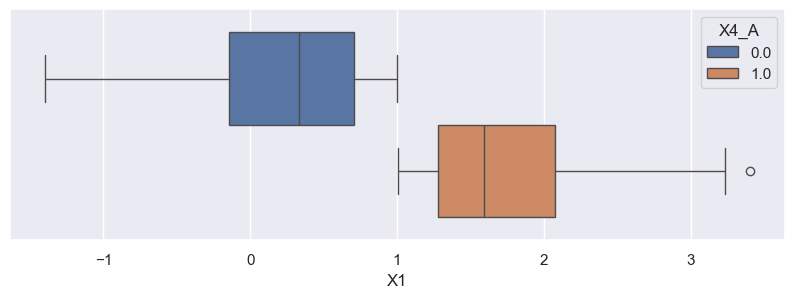

In [38]:
sns.set(rc={'figure.figsize':(10, 3)});
sns.boxplot(XTR, x = "X1", hue = "X4_A");
plt.show();plt.close(); 

---

# Prediction and Model Performance Measures in Classification

::: {.callout-note  icon=false}

### Model Predictions

We have already fitted some models and so it is time to ask ourselves how good they are. And to measure their performance we need to look at the model predictions, using the methods provided by the pipeline. We store the predictions along with the train data (inputs and output) in a new dataframe; this will become handy when we need to compare models. 

:::

In [39]:
dfTR_eval = XTR.copy()
dfTR_eval['Y'] = YTR 

::: {.callout-note  icon=false}

### Probability (Soft) Predictions

Recall that the predictions of logistic models come in the form of probability estimates. We obtain them with the `predict_proba` method like this:

:::

In [40]:
dfTR_eval['Y_LR_prob_neg'] = LogReg_pipe.predict_proba(XTR)[:, 0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_pipe.predict_proba(XTR)[:, 1]


::: {.callout-tip  icon=false}

### Exercise 006

Check the result exploring `dfTR_eval` with the `head` method. 

:::

---

::: {.callout-note  icon=false}

### Class (Hard) Predictions

To turn a probability prediction into a class prediction we need to set a **threshold**. For example, with a threshold of $0.7$ we assign class $Y = 1$ to every observation whose predicted probability for $Y=1$ is greater or equal to $0.7$. And of course we predict $Y = 0$ for the remaining observations. We will discuss below how to choose that threshold.

The scikit-learn pipeline includes a `predict` method that uses a default $0.5$ threshols to predict the class.

:::

In [41]:
dfTR_eval['Y_LR_pred'] = LogReg_pipe.predict(XTR)


::: {.callout-tip  icon=false}

### Exercise 007

Again use the `head` method to check the result. And confirm that the threshold used equals $0.5$. Hint: see the [pandas crosstab function](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html). How would you define `Y_LR_pred` using a $0.7$ threshold?

:::

---

::: {.callout-note  icon=false}

### The Confusion Matrix

After (choosing the threshold and) predicting classes, the confusion matrix summarizes the agreement between the model predictions and the true values of $Y$ in a two way table. The `scikit-learn.metrics` provides `ConfusionMatrix` to obtain this table and `ConfusionMatrixDisplay` for a convenient visualization.. 

:::

Let us obtain the confusion matrix for the train set:

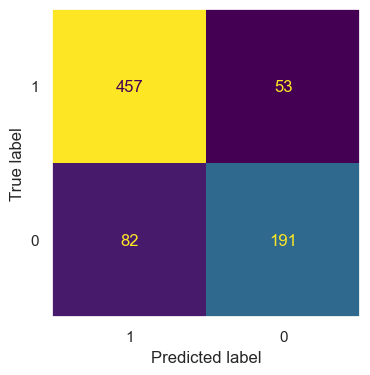

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cfm_TR = confusion_matrix(y_true= dfTR_eval["Y"], y_pred= dfTR_eval["Y_LR_pred"], labels=[1, 0])
plt.rcParams['axes.grid'] = False;plt.rcParams['figure.figsize'] = [4, 4];
cfm_display = ConfusionMatrixDisplay(cfm_TR, display_labels=[1, 0]).plot(colorbar=False);
plt.show();plt.close(); 
plt.rcParams.update(plt.rcParamsDefault)


---

::: {.callout-note  icon=false}

### Performance Measures Defined Using the Confusion Matrix

The main diagonal elements in the confusion matrix represent the cases where the model is doing right: true positives and true negatives. The elements in the other cells represent the two types of classification mistakes that the model can make: false positives and false negatives.

:::

![](./fig/02-05-ConfusinMatrix_CellNames.png){width=25% fig-align="center" fig-alt="Confusion Matrix Cell Names"}

::: {.callout-note  icon=false}

### Accuracy

Is the proportion of well classified cases:

$$\text{Accuracy} = \dfrac{TP + TN}{TP + FP + TN + FN}$$

:::


But there are many other performance measures to be derived from a confusion matrix.

---

::: {.callout-note  icon=false}

### Basic Additional Performance Measures (Based on Class Prediction)

Why do we need more performance measures? Two main reasons:

+ False positives and false negatives may not be equally important for us.
+ Accuracy does not take balance between classes into account.

:::



$$
\begin{array}{lcl}
\textbf{{Using real values as denominators:}}&&\\[2mm]
\text{Sensitivity or Recall or TPR} = \dfrac{TP}{TP + FN} &&
\text{Specificity or TNR} = \dfrac{TN}{TN + FP}\\[3mm]
\text{FPR} = 1 - \text{Specificity} = \dfrac{FP}{TN + FP} &&\\[4mm]
\textbf{Using predictions as denominator:}&&\\[2mm]
\text{Precision} = \dfrac{TP}{TP + FP}&&
\end{array}
$$


---

::: {.callout-note  icon=false}

### Extracting Performance Measures from the Confusion Matrix

With the following code we store those quantities with convenient notation:

:::

In [43]:
TP, FN, FP, TN = cfm_TR .ravel()

::: {.callout-tip  icon=false}

### Exercise 008

Use them to compute accuracy, sensitivity, specificity and precision for our example. 

:::

::: {.callout-note  icon=false}

### Performance Measures (for Class Predicition) in scikit-learn

The library provides some of these measures in the metrics submodule.

:::

In [44]:
from sklearn.metrics import accuracy_score, recall_score
acc = accuracy_score(y_true= dfTR_eval['Y'], y_pred= dfTR_eval['Y_LR_pred'])
recall = recall_score(y_true= dfTR_eval['Y'], y_pred= dfTR_eval['Y_LR_pred'])
print(f"Accuracy = {acc:.3f}") 
print(f"Recall = {recall:.3f}") 

Accuracy = 0.828
Recall = 0.896


---

::: {.callout-note  icon=false}

### Other Class Prediction Performance Measures: F1

Precision and recall are widely used to measure theperformance of a classifier when the importance of both classes is not the same. But neither of them by itself gives a full picture. The **F1-measure (or F1-score)** tries to combine them into a single number as follows:

$$\text{F1-score} = \dfrac{2\cdot\text{Precision}\,\cdot\,\text{Recall}}{\text{Precision} + \text{Recall}} \quad (\text{Harmonic mean of Precision and Recall})$$

The closer than F1 is to 1, the better. You can get its value from scikit-learn as follows.

:::

In [45]:
from sklearn.metrics import f1_score, cohen_kappa_score
f1 = f1_score(y_true= dfTR_eval['Y'], y_pred= dfTR_eval['Y_LR_pred'])
print(f"F1-score = {f1:.3f}") 



F1-score = 0.871


---

::: {.callout-note  icon=false}

### Other Class Prediction Performance Measures: Kappa

The [**Kappa (Cohen's) score**](https://en.wikipedia.org/wiki/Cohen%27s_kappa#Interpreting_magnitude) tries to take into account the class distributions of the training set samples. It is defined as 
$$\kappa = \dfrac{\text{Accuracy} - \text{RandomAgreement}}{1  - \text{RandomAgreement}}$$
where 
$$ \text{RandomAgreement} = \dfrac{(TP \cdot FP)(TP \cdot FN)}{Total^2} + \dfrac{(TN \cdot FP)(TN \cdot FN)}{Total^2}$$
and $Total = TP + FP + TN + FN$. The $\text{RandomAgreement}$ term measures the probability of correcty selecting the class when coosing at random.

Kappa is standardized to take values between -1 and 1. A value of 1 means perfect classification, 0 corresponds to random class selection, and negative values indicate performance worse than randomly choosing.  Kappa values from 0.6 to 1 is [sometimes interpreted as substantial to excellent agreement](https://en.wikipedia.org/wiki/Cohen%27s_kappa#Interpreting_magnitude:~:text=Interpreting-,magnitude,-%5Bedit%5D).


:::

In [46]:
kappa = cohen_kappa_score(y1= dfTR_eval['Y'], y2= dfTR_eval['Y_LR_pred'])
print(f"Kappa = {kappa:.3f}") 

Kappa = 0.611


---

::: {.callout-note  icon=false}

### Performance Measures Based on Probability Prediction. 

We have emphasized in the previous paragraphs that the performance measures we have been discussing assume in all cases that we are using classes as predictions (what we called the hard approach to classification).  But the class prediction is often the result of selecting a threshold and applying it to a classifier that predicts scores or probabilities. And therefore its performance depends on the choice of the threshold. In this section we are going to explore this dependency and introduce some performance measures directly based on the probabilities or scores.

:::


::: {.callout-tip  icon=false}

### Exercise 009

In a previous exercise we asked you to define `Y_LR_pred` using a $0.7$ threshold. Do it now using a general threshold stored in the variable `thrs` (initially set to 0.7).  Store the resultin class predictions in a column of `dfTR_eval` called `Y_LR_pred_thrs`. Use that column to compute the true positive rate (tpr) and false positive rate (fpr) corresponding to that threshold.

**Important:** after doing that, and **without using Python** what do you **think** will happen to tpr and fpr as you move the threshold closer to 1? And if you move it closer to 0? Think it through before checking your ideas with Python!

:::

In [47]:
# %load "../exclude/code/2_2_Exercise_009.py"

---

::: {.callout-note  icon=false}

### ROC Curve

The ROC curve (receiver operator characteristic curve, [terminology from Signal Theory](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) is defined using all possible thresholds. The points in the curve have coordinates `(fpr, tpr)`, going from (0, 0) for a threshold equal to 1, to (1, 1) when the threshold is 0. In scikit-learn we can get these values of fpr, tpr and the associated threshold with `roc_curve`.

:::

For high thresholds (we store all three values in a pandas dataframe):

In [48]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(YTR, dfTR_eval["Y_LR_prob_pos"], pos_label=1)
df_roc = pd.DataFrame({'fpr':fpr, 'tpr': tpr, 'thresholds':thresholds})
df_roc.head(4)

,fpr,tpr,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.001961,0.999878
2,0.000000,0.623529,0.885624
3,0.003663,0.623529,0.883314


and for low thresholds:

In [49]:
df_roc.tail(4)

,fpr,tpr,thresholds
166,0.937729,0.998039,0.018814
167,0.956044,0.998039,0.013671
168,0.956044,1.000000,0.011634
169,1.000000,1.000000,0.001451


---

::: {.callout-note  icon=false}

### Plot of the ROC Curve

To actually plot the ROC curve we will use the following code. We will expain shortly some elments of that plot.

:::


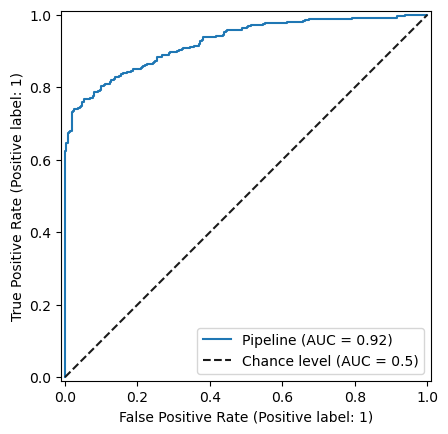

In [50]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(LogReg_pipe, XTR, YTR, plot_chance_level=True);
plt.show();plt.close(); 

---

::: {.callout-note  icon=false}

### ROC Curve and Classifier Performance. AUC.

How can we use the ROC curve to judge the performance of a classifier? A good classifier is expected to have low `fpr` (close to 0) and high `fpr` (close to 1). IN fact a perfect classifier (one that always gets it right) has precisely `fpr` = 0, `tpr` = 1. Therefore a good classifier has a ROC curve that comes very close to the upper left corner of the plot (the point (0, 1)).  

In particular that means (because the ROC curve is monotonic) that the area of a good classifier is close to 1, the total area of the square. That leads to the definition o a widely used measure of classifier performance: **the ROC AUC (area under the curve)**.

To obtain the ROC AUC in Python use the code below. Recall tha we obtained `fpr, tpr` previously with `roc_curve`,

:::


In [51]:
from sklearn.metrics import roc_curve, auc
auc(fpr, tpr)

0.924750412985707

---

::: {.callout-note  icon=false}

### Random Classifier.

The **random classifier** assigns scores to the observations using a uniform distribution in $[0, 1]$ without regard to the real classes. Therefore, for any given threshold $0\leq p\leq 1$ the *expected* amount of positive predictions is $p$, *both for real negatives and for real positives*.  That means 
$$\dfrac{FP}{FP + TN} = \dfrac{TP}{TP + FN}$$
That is `fpr` = `tpr`.And this means that for a random classifier we expect the point `(fpr, tpr)` to be in the diagonal that we represented as a dashed line in the ROC curve plot.  

We emphasize that this are expected `tpr` and `fpr` values because in a specific implementation of a random classifier the values will usually deviate from their 
theoretical expectation.

The area under a random classifiier ROC is 0.5. A classifier with a value close to this one is almost random and a classifier with smaller AUC is called *worse than random*.

:::


::: {.callout-tip  icon=false}

### Exercise 010
Implement the random classifier and check its fpr, tpr values.

:::

In [52]:
# %load "../exclude/code/2_2_Exercise_010.py"

---

::: {.callout-note  icon=false}

### Scores and Calibration

In the previous session we explained that many classifiers, even when using the soft approach, return ordered scores and not probabilities. That is why, when we need to interpret these scores as probabilities we need to think about **calibration**. Recall that a perfectly calibrated scoring means that if we take 100 predictions of the model, all of them with score 0.7, then seventy of them shoul be real positives and 30 should be real negatives. 

In the case of logistic regression the model is based on estimated probabilities. So we usually expect logistic classifiers to be fairly well calibrated. Note however that there are factors (i.e. imbalance) that affect calibration, and so perfect calibration is not attained in practice.

:::


::: {.callout-note  icon=false}

### Calibration Curves

In order to assess if a classifier is well calibrated we can bin the scores it outputs and compute the relative frequency of the positive class in each bin. If the classifier is well calibrated when we plot the bin centers against the relative frequency, the points should lie in or close to the diagonal line of the unit square. This is what a calibration curve is for, to check how close to the ideal is the output of our classifier.

:::



---

::: {.callout-note  icon=false}

### Calibration Curves with scikit-learn

The code is similar to what we did for ROC curves. The predictions of the logistic classifier are reasonably close to the dashed line. 

:::



<Figure size 600x400 with 0 Axes>

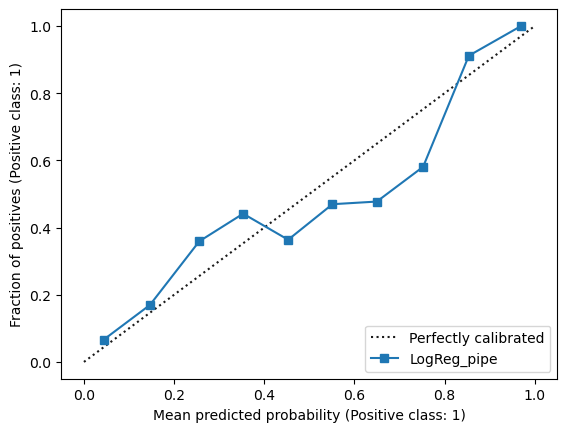

In [53]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

fig = plt.figure(figsize=(6, 4))
CD = CalibrationDisplay.from_estimator(LogReg_pipe, XTR, YTR, n_bins=10,
                                  name="LogReg_pipe", pos_label = 1)
plt.show();plt.close(); 

---

::: {.callout-note  icon=false}

### Probability Histograms

These are histograms of the scores assigned by the classifier for real negatives (left panel) and real positives (right panel). For a perfect classifier you should see a single red bar at the leftmost position for $Y=0$ and a single blue bar at the righmost position for $Y=1$. But for non perfect classifiers the scores leak to the rest of the interval. The wider their distribution, the worse the performance in the class indicated by the value of $Y$.

Keep in mind that **the vertical scales are not the same!** The code to obtain this plots is a bit more involved so use the magic `%load` to inspect it.

:::



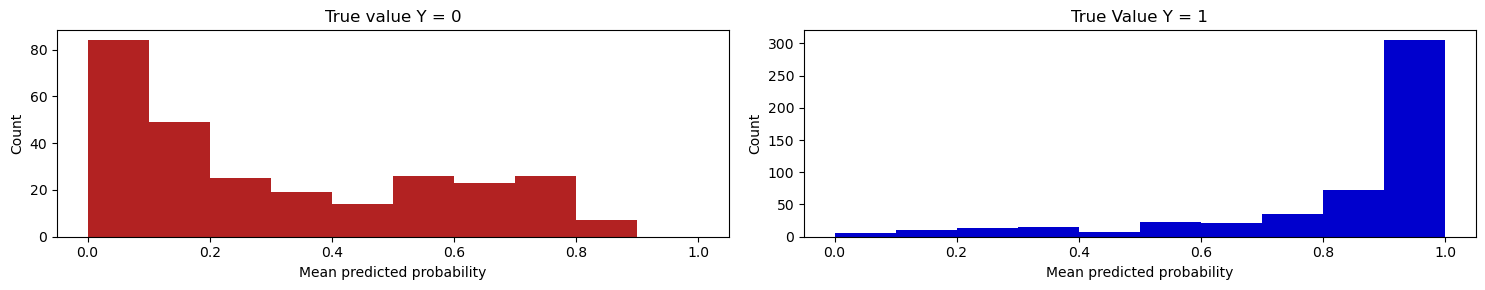

In [54]:
%run -i "2_2_probability_histograms.py"

---

---

::: {.callout-note  icon=false}

### Performance Measures and Plots for the Test Set

Everything that we have done regarding performance has used the training set. In order to see how our model behaves with data that it has not seen before we should now explore the performance of the model using the test set. 

<p style="color:red;text-decoration: underline;font-weight: bold;.">The following exercise is very important! </p>

:::




::: {.callout-tip  icon=false}

### Exercise 011

+ Create a dataframe called `dfTS_eval` from `XTS` and `YTS`
+ Obtain the test set predictions of the model (both class and probability) and store them in `dfTS_eval`.
+ Get the confusion matrix, accuracy, sensitivity, specificity, precision, f1 and kappa for the test set.
+ Find the ROC AUC and plot the ROC curve, calibration curve and probability histograms.
+  Compare your results with those from training. What are you conclusions?

:::

---

# Let us Talk about Books

![](./fig/02-02-MachineLearningForDogs.png){width=25% fig-align="center" fig-alt="Generated with CoPilot"}

Along the course we will introduce book and web references we consider worth knowing. We begin with a list of recommended books (details in the references section below, pdf and html versions of this document):

+ [@ISLP2023] *An Introduction to Statistical Learning, with Applications in Python (2023)*, by . Visit [https://www.statlearning.com/](https://www.statlearning.com/)
+ [@ESLI2009] *The Elements of Statistical Learning (2009)* by T. Hastie, R. Tibshirani & J. Friedman. Be sure to visit the Publications section of [https://hastie.su.domains/](https://hastie.su.domains/)
+ [@pml1] *Probabilistic Machine Learning* (2022). Two volume set by K. Murphy. Visit [https://probml.github.io/pml-book/](https://probml.github.io/pml-book/). 
+ [@Geron2022] *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2022). by A. Geron. Visit [https://www.oreilly.com/library/view/hands-on-machine-learning/9781492087616/](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492087616/) 
+ [@IMLPY] *Introduction to Machine Learning with Python (2017)* by A.C. Muller, S.Guido. Visit [https://amueller.github.io/#book](https://amueller.github.io/#book)
+ [@PDSH] *Python Data Science Handbook (2016)* by J. VanderPlas. Visit [https://jakevdp.github.io/PythonDataScienceHandbook/](https://jakevdp.github.io/PythonDataScienceHandbook/)



---

::: {.callout-note  icon=false}

## In the Next Session

Logistic Regression models are well studied and widely used models and we have barely scratched the surface of the topic. They are however limited to problems with a linear boundary between classes (unless we add well chosen nonlinear terms). They are fast to train and predict, they do not overfit easily but they are not flexible enough for more complex problems and they do not extend easily to multiclass problems.

In our next session we will meet the KNN models. This will lead us to consider the notion of hyperparameter of a model. And that in turn will open a deeper discussion about model validation and generalization. 

:::

---

# References